# Objective Functions: A Simple Example with Matrix Factorisation.

### 6th October 2015 Neil D. Lawrence

### Modified by Mauricio A Álvarez, 1st October 2018

In last week's class we saw how we could load in a data set to pandas and use it for some simple data processing. We computed various probabilities on the data and I encouraged you to think about what sort of probabilities you need for prediction. This week we are going to take a slightly different tack. 

Broadly speaking there are two dominating approaches to machine learning problems. We started to consider the first approach last week: constructing models based on defining the relationship between variables using probabilities. This week we will consider the second approach: which involves defining an *objective function* and optimizing it. 

What do we mean by an objective function? An objective function could be an *error function*, a *cost function* or a *benefit* function. In evolutionary computing they are called *fitness* functions. But the idea is always the same. We write down a mathematical equation which is then optimized to do the learning. The equation should be a function of the *data* and our model *parameters*. We have a choice when optimizing, either minimize or maximize. To avoid confusion, in the optimization field, we always choose to minimize the function. If we have a function that we would like to maximize, we simply choose to minimize the negative of that function. 

So for this lab session, we are going to ignore probabilities, but don't worry, they will return! 

This week we are going to try and build a simple movie recommender system using an objective function. To do this, the first thing I'd like you to do is to install some software we've written for sharing information across google documents.

## Open Data Science Software

In Sheffield we have written a suite of software tools for 'Open Data Science'. Open data science is an approach to sharing code, models and data that should make it easier for companies, health professionals and scientists to gain access to data science techniques. For some background on open data science you can read [this blog post](http://inverseprobability.com/2014/07/01/open-data-science/). The first thing we will do this week is to download that suite of software. 

The software can be installed using

```python
pip install pods
```

from the command prompt where you can access your python installation.


## Download the MovieLens 100k Data

We are going to download the [MovieLens 100k](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) Data. This is a public dataset that contains 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. When you use a data set that someone has prepared you should always reference the data source to acknowledge the work that's been placed in. This particular dataset was collected by the [Grouplens Research group](https://grouplens.org/),  at the University of Minnesota. For example, if you were to use this dataset for writing a paper, the authors ask you that you acknowledge their work by citing the following paper:

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5 (4):1-19 [https://doi.org/10.1145/2827872](https://doi.org/10.1145/2827872)

In [1]:
import pods
import zipfile
import sys
import pandas as pd
import numpy as np

pods.util.download_url("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
zip_console = zipfile.ZipFile('ml-latest-small.zip', 'r')
for name in zip_console.namelist():
           zip_console.extract(name, './')

[==============================]   0.933/0.933MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

### Assignment Question 1

Data ethics. If you find data available on the internet, can you simply use it without consequence? If you are given data by a fellow researcher can you publish that data on line? 

*5 marks*

#### Question 1 Answer

Write your answer to the question in this box.

Under traditional ethics framework, I should not simply use the data available on internet without knowing its consequence. Every human being value their privacy and protection of personal data. But recent advances in the technologies have threaten privacy and the amount of control over the use of personal data. One should always follow the ethical guidelines before using any data on the internet.

I cannot publish any data online given by the researchers. Moreover, it is also incorrect that the researcher gives the data without considering data ethics. He should follow some data ethics framework and guidelines like Informed consent, Be aware of relevant legislation and codes of practice etc.

## Recommender Systems

A recommender system aims to make suggestions for items (films, books, other commercial products) given what it knows about users' tastes. The recommendation engine needs to represent the *taste* of all the users and the *characteristics* of each object. 

A common way for organizing objects is to place related objects spatially close together. For example in a library we try and put books that are on related topics near to each other on the shelves. One system for doing this is known as [Dewey Decimal Classification](http://en.wikipedia.org/wiki/Dewey_Decimal_Classification). In the Dewey Decimal Classification system (which dates from 1876) each subject is given a number (in fact it's a decimal number). For example, the field of Natural Sciences and Mathematics is given numbers which start with 500. Subjects based on Computer Science are given numbers which start 004 and works on the 'mathematical principles' of Computer science are given the series 004.0151 (which we might store as 4.0151 on a Computer). Whilst it's a classification system, the books in the library are typically laid out in the same order as the numbers, so we might expect that neighbouring numbers represent books that are related in subject. That seems to be exactly what we want when also representing films. Could we somehow represent each film's subject according to a number? In a similar way we could then imagine representing users with a list of numbers that represent things that each user is interested in.

Actually a one dimensional representation of a subject can be very awkward. To see this, let's have a look at the Dewey Decimal Classification numbers for the 900s, which is listed as 'History and Geography'. We will focus on subjects in the 940s which can be found in this list from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Dewey_Decimal_classes#Class_900_%E2%80%93_History_&_geography). Whilst the ordering for places is somewhat sensible, it is also rather arbitrary. In the 940s we have Europe listed from 940-949, Asia listed from 950-959 and Africa listed from 960-969. Whilst it's true that Asia borders Europe, Africa is also very close, and the history of the Roman Empire spreads into [Carthage](http://en.wikipedia.org/wiki/Carthage) and later on Egypt. This image from Wikipedia shows a map of the Cathaginian Empire which fell after fighting with Rome. 


<a title="By Javierfv1212 [Public domain], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Carthaginianempire.PNG"><img width="512" alt="Carthaginianempire" src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9b/Carthaginianempire.PNG/512px-Carthaginianempire.PNG"></a>

We now need to make a decision about whether Roman Histories are European or African, ideally we'd like them to be somewhere between the two, but we can't place them there in the Dewey Decimal system because between Europe and Africa is Asia, which has less to do with the Roman Empire than either Europe or Africa. Of course the fact that we've used a map provides a clue as to what to do next. Libraries are actually laid out on floors, so what if we were to use the spatial lay out to organise the sujbects of the books in two dimensions. Books on Geography could be laid out according to where in the world they are referring to. 

Such complexities are very hard to encapsulate in one number, but inspired by the map examples we can start considering how we might lay out films in two dimensions. Similarly, we can consider laying out a map of people's interests. If the two maps correspond to one another, the map of people could reflect where they might want to live in 'subject space'. We can think of representing people's tastes as where they might best like to sit in the library to access easily the books they are most interested in.


## Inner Products for Representing Similarity

Ideas like the above are good for gaining intuitions about what we might want, but the one of the skills of data science is representing those ideas mathematically. Mathematical abstraction of a problem is one of the key ways in which we've been able to progress as a society. Understanding planetary motions, as well as those of the smallest molecule (to quote Laplace's [Philosophical Essay on Probabilities](http://books.google.co.uk/books?id=1YQPAAAAQAAJ&printsec=frontcover&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false)) needed to be done mathematically. The right mathematical model in machine learning can be slightly more elusive, because constructing it is a two stage process. 

1. We have to determine the right intuition for the system we want to represent. Notions such as 'subject' and 'interest' are not mathematically well defined, and even when we create a new interpretation of what they might mean, each interpretation may have its own weaknesses. 

2. Once we have our interpretation we can attempt to mathematically formalize it. In our library interpretation, that's what we need to do next. 

### The Library on an Infinite Plane

Let's imagine a library which stores all the items  we are interested in, not just books, but films and shopping items too. Such a library is likely to be very large, so we'll create it on an infinite two dimensional plane. This means we can use all the real numbers to represent the location of each item on the plane. For a two dimensional plane, we need to store the locations in a vector of numbers: we can decide that the $j$th item's location in the library is given by 
$$
\mathbf{v}_j = \begin{bmatrix} v_{j,1} \\ v_{j,2}\end{bmatrix},
$$
where $v_{j,1}$ represents the $j$th item's location in the East-West direction (or the $x$-axis) and $v_{j,2}$ represents the $j$th item's location in the North-South direction (or the $y$-axis). Now we need to specify the location where each user sits so that all the items that interest them are nearby: we can also represent the $i$th user's location with a vector 
$$
\mathbf{u}_i = \begin{bmatrix} u_{i,1} \\ u_{i,2}\end{bmatrix}.
$$
Finally, we need some way of recording a given user's affinity for a given item. This affinity might be the rating that the user gives the film. We can use $y_{i,j}$ to represent user $i$'s affinity for item $j$. 

For our film example we might imagine wanting to order films in a few ways. We could imagine organising films in the North-South direction as to how romantic they are. We could place the more romantic films further North and the less romantic films further South. For the East-West direction we could imagine ordering them according to how historic they are: we can imagine placing science fiction films to the East and historical drama to the West. In this case, fans of historical romances would be based in the North-West location, whilst fans of Science Fiction Action films might be located in the South-East (if we assume that 'Action' is the opposite of 'Romance', which is not necessarily the case). How do we lay out all these films? Have we got the right axes? In machine learning the answer is to 'let the data speak'. Use the data to try and obtain such a lay out. To do this we first need to obtain the data.

## Obtaining the Data

As mentioned before, the MovieLens dataset that we'll use has 100,000 ratings to 9,000 movies by 600 users. For now, we will only work with a subset of the dataset. In particular, we will randomly chose a particular number of users and extract the movies and ratings that the users gave to those movies. Read the code below and understand what it is doing.

**Before you run the code**, notice that `YourStudentID` in the first line is a variable that will specify the seed for the random number generator that will select a particular set of `nUsersInExample` users. Change the number that has been assigned by default to `YourStudentID` to the last three digits of your UCard number. All of you will have a different subset of users.

In [2]:
YourStudentID = 356  # Include here the last three digits of your UCard number
nUsersInExample = 10 # The maximum number of Users we're going to analyse at one time

ratings = pd.read_csv("./ml-latest-small/ratings.csv") 
"""
ratings is a DataFrame with four columns: userId, movieId, rating and tags. We
first want to identify how many unique users there are. We can use the unique 
method in pandas
"""
indexes_unique_users = ratings['userId'].unique()
n_users = indexes_unique_users.shape[0]   #shape is used to get the current shape of the array
#print(n_users)
""" 
We randomly select 'nUsers' users with their ratings. We first fix the seed
of the random generator to make sure that we always get the same 'nUsers'
"""
np.random.seed(YourStudentID)
indexes_users = np.random.permutation(n_users)  #Randomly permute a sequence, or return a permuted range.
my_batch_users = indexes_users[0:nUsersInExample]
#print(my_batch_users)
"""
We will use now the list of 'my_batch_users' to create a matrix Y. 
"""
# We need to make a list of the movies that these users have watched
list_movies_each_user = [[] for _ in range(nUsersInExample)]
list_ratings_each_user = [[] for _ in range(nUsersInExample)]
# Movies
list_movies = ratings['movieId'][ratings['userId'] == my_batch_users[0]].values
list_movies_each_user[0] = list_movies 
#print(list_movies)
# Ratings                      
list_ratings = ratings['rating'][ratings['userId'] == my_batch_users[0]].values
list_ratings_each_user[0] = list_ratings
#print(list_ratings)
# Users
n_each_user = list_movies.shape[0]
#print(n_each_user)
list_users = my_batch_users[0]*np.ones((1, n_each_user)) #np.ones > Return a new array of given shape and type, filled with ones


for i in range(1, nUsersInExample):
    # Movies
    local_list_per_user_movies = ratings['movieId'][ratings['userId'] == my_batch_users[i]].values
    list_movies_each_user[i] = local_list_per_user_movies
    list_movies = np.append(list_movies,local_list_per_user_movies)
    # Ratings                                 
    local_list_per_user_ratings = ratings['rating'][ratings['userId'] == my_batch_users[i]].values
    list_ratings_each_user[i] = local_list_per_user_ratings
    list_ratings = np.append(list_ratings, local_list_per_user_ratings)  
    # Users                                   
    n_each_user = local_list_per_user_movies.shape[0]                                                                               
    local_rep_user =  my_batch_users[i]*np.ones((1, n_each_user))    
    list_users = np.append(list_users, local_rep_user)

# Let us first see how many unique movies have been rated
indexes_unique_movies = np.unique(list_movies)
n_movies = indexes_unique_movies.shape[0]
#print(n_movies)
# As it is expected no all users have rated all movies. We will build a matrix Y 
# with NaN inputs and fill according to the data for each user 
temp = np.empty((n_movies,nUsersInExample,))
temp[:] = np.nan
Y_with_NaNs = pd.DataFrame(temp)
for i in range(nUsersInExample):
 local_movies = list_movies_each_user[i]
 ixs = np.in1d(indexes_unique_movies, local_movies)
 Y_with_NaNs.loc[ixs, i] = list_ratings_each_user[i]
print(Y_with_NaNs)
Y_with_NaNs.index = indexes_unique_movies.tolist()
Y_with_NaNs.columns = my_batch_users.tolist()

       0    1    2   3    4    5    6    7    8    9
0    NaN  NaN  NaN NaN  5.0  4.5  4.0  5.0  2.0  4.0
1    NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  3.5
2    NaN  NaN  NaN NaN  NaN  NaN  4.0  NaN  NaN  NaN
3    NaN  NaN  NaN NaN  3.0  NaN  NaN  NaN  NaN  NaN
4    4.0  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN
5    NaN  NaN  NaN NaN  4.0  NaN  3.0  NaN  NaN  NaN
6    NaN  NaN  NaN NaN  NaN  NaN  3.0  NaN  NaN  NaN
7    NaN  NaN  NaN NaN  4.0  NaN  NaN  3.0  NaN  3.5
8    NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  3.5
9    NaN  NaN  NaN NaN  3.0  NaN  NaN  NaN  NaN  NaN
10   NaN  NaN  NaN NaN  NaN  NaN  4.0  NaN  NaN  NaN
11   NaN  NaN  NaN NaN  NaN  NaN  3.0  NaN  NaN  NaN
12   NaN  NaN  NaN NaN  2.0  NaN  NaN  NaN  NaN  4.0
13   4.0  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN
14   3.5  NaN  NaN NaN  NaN  NaN  4.0  4.0  NaN  4.0
15   NaN  NaN  NaN NaN  NaN  NaN  5.0  NaN  NaN  3.5
16   NaN  NaN  NaN NaN  NaN  NaN  NaN  3.0  NaN  3.0
17   NaN  2.0  NaN NaN  NaN  NaN  4.0  NaN  Na

In [3]:
n_users = indexes_unique_users.shape

### Assignment Question 2

Have a look at the matrix `Y_with_NaNs`. The movies data is now in a data frame which contains one column for each user rating the movie. There are some entries that contain 'NaN'. What does the 'NaN' mean in this context?

*5 marks*

#### Answer Question 2

Write your answer to the question in this box.

Here we have generated random 10 users ( i.e. [ 23  75  296  547  31  562  179  46  193  570 ] ) considering the YourStudentID = 356. Using the following information we have calculated the total number of unique movies ( i.e. 590 ) that are rated by all of these 10 users. But as every movie is not rated by every user , we have feed that user-movie pair in the data frame with NaN input.

Now we will convert our data structure into a form that is appropriate for processing. We will convert the `Y_with_NaNs` dataframe into a new dataframe which contains the user, the movie, and the rating using the following code

In [4]:
p_list_ratings = np.concatenate(list_ratings_each_user).ravel()  # np.ravel > A 1-D array, containing the elements of the input, is returned
#print(list_ratings_each_user)
#print(type(p_list_ratings))
p_list_ratings_original = p_list_ratings.tolist()
mean_ratings_train = np.mean(p_list_ratings)  # returns average of array elements
#print(mean_ratings_train)
p_list_ratings =  p_list_ratings - mean_ratings_train # remove the mean
p_list_movies = np.concatenate(list_movies_each_user).ravel().tolist()
p_list_users = list_users.tolist()
Y = pd.DataFrame({'users': p_list_users, 'movies': p_list_movies, 'ratingsorig': p_list_ratings_original,'ratings':p_list_ratings.tolist()})
print(Y)

     movies   ratings  ratingsorig  users
0         6  0.238318          4.0   23.0
1        29  0.238318          4.0   23.0
2        32 -0.261682          3.5   23.0
3        50  0.238318          4.0   23.0
4        58 -0.761682          3.0   23.0
5       175 -0.761682          3.0   23.0
6       272  0.238318          4.0   23.0
7       293  0.238318          4.0   23.0
8       296 -0.261682          3.5   23.0
9       300 -0.761682          3.0   23.0
10      334  0.238318          4.0   23.0
11      431 -0.761682          3.0   23.0
12      454 -1.261682          2.5   23.0
13      541  1.238318          5.0   23.0
14      608 -0.261682          3.5   23.0
15      741  0.238318          4.0   23.0
16      750 -0.761682          3.0   23.0
17      778  0.238318          4.0   23.0
18      858 -0.261682          3.5   23.0
19      866 -0.761682          3.0   23.0
20      904 -0.261682          3.5   23.0
21      912 -0.261682          3.5   23.0
22      913  0.238318          4.0

### Assignment Question 3

The dataframes `Y_with_NaNs` and `Y` contain the same information but organised in a different way. Explain what is the difference. We have also included two columns for ratings in dataframe `Y`, `ratingsorig` and `ratings`. Explain
the difference. 

*10 marks*

#### Question 3 Answer

Write your answer to the question in this box.

The dataframes Y_with_NaNs and Y contains same information. But the dataframe Y_with_NaNs contains the information that is not significant or can be omitted. Y_with_NaNs dataframe also contains the data for the user-movie pair where the user has not rated for that particular movie and is indicated with NaN.

Whereas dataframe Y contains only the user-movie information that is significant. It contains the information only for the movies that are rated by each user. It also includes additional two columns as ratingsorig and ratings.

The ratingsorig are the original ratings that are given by the users. These ratings are given out of 10. Whereas values in ratings columns gives data with new mean set to zero. This is called zero-centering. Thus the mean lies on zero. This allows different data sets to be compared and allows to analyze the data that how it varies about the mean. This further can be used for normalizing and standardizing the data.

## Measuring Similarity

We now need a measure for determining the similarity between the item and the user: how close the user is sitting to the item in the rooom if you like. We are going to use the inner product between the vector representing the item and the vector representing the user. 

An inner product (or [dot product](http://en.wikipedia.org/wiki/Dot_product)) between two vectors $\mathbf{a}$ and $\mathbf{b}$ is written as $\mathbf{a}\cdot\mathbf{b}$. Or in vector notation we sometimes write it as $\mathbf{a}^\top\mathbf{b}$. An inner product is simply the sume of the products of each element of the vector,
$$
\mathbf{a}^\top\mathbf{b} = \sum_{i} a_i b_i
$$
The inner product can be seen as a measure of similarity. The inner product gives us the cosine of the angle between the two vectors multiplied by their length. The smaller the angle between two vectors the larger the inner product. 
$$
\mathbf{a}^\top\mathbf{b} = |\mathbf{a}||\mathbf{b}| \cos(\theta)
$$
where $\theta$ is the angle between two vectors and $|\mathbf{a}|$ and $|\mathbf{b}|$ are the respective lengths of the two vectors.

Since we want each user to be sitting near each item, then we want the inner product to be large for any two items which are rated highly by that user. We can do this by trying to force the inner product $\mathbf{u}_i^\top\mathbf{v}_j$ to be similar to the rating given by the user, $y_{i,j}$. To ensure this we will use a least squares objective function for all user ratings.

## Objective Function

The error function (or objective function, or cost function) we will choose is known as 'sum of squares', we will aim to minimize the sum of squared squared error between the inner product of $\mathbf{u}_i$ and $\mathbf{v}_i$ and the observed score for the user/item pairing, given by $y_{i, j}$. 

The total objective function can be written as
$$
E(\mathbf{U}, \mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$
where $s_{i,j}$ is an *indicator* variable that is 1 if user $i$ has rated item $j$ and is zero otherwise. Here $\mathbf{U}$ is the matrix made up of all the vectors $\mathbf{u}$,
$$
\mathbf{U} = \begin{bmatrix} \mathbf{u}_1 \dots \mathbf{u}_n\end{bmatrix}^\top
$$
where we note that $i$th *row* of $\mathbf{U}$ contains the vector associated with the $i$th user and $n$ is the total number of users. This form of matrix is known as a *design matrix*. Similarly, we define the matrix
$$
\mathbf{V} = \begin{bmatrix} \mathbf{v}_1 \dots \mathbf{v}_m\end{bmatrix}^\top
$$
where again the $j$th row of $\mathbf{V}$ contains the vector associated with the $j$th item and $m$ is the total number of items in the data set.

## Objective Optimization

The idea is to mimimize this objective. A standard, simple, technique for minimizing an objective is *gradient descent* or *steepest descent*. In gradient descent we simply choose to update each parameter in the model by subtracting a multiple of the objective function's gradient with respect to the parameters. So for a parameter $u_{i,j}$ from the matrix $\mathbf{U}$ we would have an update as follows:
$$
u_{k,\ell} \leftarrow u_{k,\ell} - \eta \frac{\text{d} E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}} 
$$
where $\eta$ (which is pronounced *eta* in English) is a Greek letter representing the *learning rate*.  

We can compute the gradient of the objective function with respect to $u_{k,\ell}$ as
$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}} = -2 \sum_j s_{k,j}v_{j,\ell}(y_{k, j} - \mathbf{u}_k^\top\mathbf{v}_{j}). 
$$
Similarly each parameter $v_{i,j}$ needs to be updated according to its gradient. 


### Assignment Question 4

What is the gradient of the objective function with respect to $v_{k, \ell}$? Write your answer in the box below, and explain which differentiation techniques you used to get there. You will be expected to justify your answer in class by oral questioning. 

*15 marks*

#### Question 4 Answer

Write your answer to the question in this box.

The diffrentiation techniques used to get to that answer were,
firstly the power rule and secondly the chain rule of diffrentiation.

## Question 4 Code Answer

$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}v_{k,\ell}} = -2 \sum_i s_{k,i}u_{i,\ell}^\top\mathbf(y_{i, k} - \mathbf{u}i^\top\mathbf{v}{k}). 
$$

## Steepest Descent Algorithm

In the steepest descent algorithm we aim to minimize the objective function by subtacting the gradient of the objective function from the parameters. 

### Initialisation

To start with though, we need initial values for the matrix $\mathbf{U}$ and the matrix $\mathbf{V}$. Let's create them as `pandas` data frames and initialise them randomly with small values.

In [5]:
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.02
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
print(U)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)
print(V)

            0         1
23  -0.000033 -0.000564
75  -0.000276  0.001285
296  0.000101  0.000686
547 -0.000138  0.000530
31  -0.000764 -0.000764
562 -0.000894  0.001008
179 -0.002097  0.000366
46   0.002717  0.000540
193  0.000680 -0.001171
570  0.001757  0.001450
               0         1
1      -0.001344 -0.001755
2       0.000033 -0.001274
3      -0.000861  0.000757
5      -0.000384  0.001156
6       0.002014 -0.000157
7       0.000951 -0.000835
9      -0.001061  0.000655
10     -0.001099 -0.000469
11      0.000362 -0.000995
17     -0.001054  0.000073
18      0.001715  0.002288
19      0.000643  0.001242
25      0.000481  0.000491
29     -0.000240  0.000218
32     -0.001697 -0.000299
34      0.000355 -0.000045
39     -0.000858  0.000049
47     -0.001212 -0.000265
50      0.001166  0.000615
52     -0.001154 -0.000615
58     -0.001521  0.001002
62     -0.000398 -0.001609
65     -0.001139 -0.000520
95     -0.000104 -0.001113
104    -0.001123  0.000658
110     0.000227  0.000043
111    

Now that we have the initial values set, we can start the optimization. First we define a function for the gradient of the objective and the objective function itself.

In [6]:
# here we are finding the gradient for the objective function
def objective_gradient(Y, U, V):
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    #print(gU)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    #print(gV)
    obj = 0.
    nrows = Y.shape[0]
    for i in range(nrows):
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
    return obj, gU, gV



Now we can write our simple optimisation route. This allows us to observe the objective function as the optimization proceeds.

In [7]:
iterations = 20
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("Iteration", i, "Objective function: ", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV 


Iteration 0 Objective function:  641.3829997326253
Iteration 1 Objective function:  641.3826968544219
Iteration 2 Objective function:  641.3822206592056
Iteration 3 Objective function:  641.3813209907053
Iteration 4 Objective function:  641.3795347339737
Iteration 5 Objective function:  641.3759183021803
Iteration 6 Objective function:  641.3685104429654
Iteration 7 Objective function:  641.353208279367
Iteration 8 Objective function:  641.3213977702343
Iteration 9 Objective function:  641.2549476329442
Iteration 10 Objective function:  641.1156255131904
Iteration 11 Objective function:  640.8227330800368
Iteration 12 Objective function:  640.2059730872627
Iteration 13 Objective function:  638.9068297526185
Iteration 14 Objective function:  636.1756827435473
Iteration 15 Objective function:  630.4704067738365
Iteration 16 Objective function:  618.7335140862577
Iteration 17 Objective function:  595.3953391782277
Iteration 18 Objective function:  552.2294435784714
Iteration 19 Objective 

### Assignment Question 5

What happens as you increase the number of iterations? What happens if you increase the learning rate?

*10 marks*

#### Question 5 Answer

Write your answer to the question in this box.

As we increase the number of iterations, the objective function decreases. The number of iterations should be increased until we hopefully end up getting the objective function minimum.

Learning rate controls how big a step we take downhill while creating descent. If learning rate is too small, then the gradient descent can be slow. Similarly if the gradient descent is too high, then gradient descent can overshoot the global minimum. So, as the learning rate is increased, it increases the step size and thus try to converge the local minimum faster. Thus learning rate is always selected with experiments.

In [8]:
# Question 5 Code Answer
iterations = 100
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("Iteration", i, "Objective function: ", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV 

Iteration 0 Objective function:  400.59961911092915
Iteration 1 Objective function:  337.2501480420378
Iteration 2 Objective function:  304.5667569434444
Iteration 3 Objective function:  284.57559239430213
Iteration 4 Objective function:  269.3613609212295
Iteration 5 Objective function:  256.22654842702553
Iteration 6 Objective function:  243.09903098576504
Iteration 7 Objective function:  229.18809155612928
Iteration 8 Objective function:  214.16118346364348
Iteration 9 Objective function:  197.5855682032214
Iteration 10 Objective function:  179.32536011016077
Iteration 11 Objective function:  160.09972889457924
Iteration 12 Objective function:  141.3007098948715
Iteration 13 Objective function:  124.14649237083586
Iteration 14 Objective function:  109.14206156005156
Iteration 15 Objective function:  96.35875893702607
Iteration 16 Objective function:  85.8513519230206
Iteration 17 Objective function:  77.60890601790979
Iteration 18 Objective function:  71.34555215659444
Iteration 19 

## Making Predictions

Predictions can be made from the model of the appropriate rating for a given user, $i$, for a given film, $j$, by simply taking the inner product between their vectors $\mathbf{u}_i$ and $\mathbf{v}_j$. 

### Assignment Question 6

Create a function that provides the prediction of the ratings for the users in the dataset. Is the quality of the predictions affected by the number of iterations or the learning rate? The function should receive `Y`, `U` and `V` and return the predictions and the absolute error between the predictions and the actual rating given by the users. The predictions and the absolute error should be added as additional columns to the dataframe `Y`.

*15 marks*

In [9]:
# Question 6 Code Answer

def prediction(Y, U, V):
    new_prediction = np.zeros((Y.shape[0]))
    new_abs_error = np.zeros((Y.shape[0]))
    sum_error = 0
    for i in range(Y.shape[0]):
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        error = prediction - rating # vTu - y
        abs_error = abs(error)  # taking absolute value of the error calculated
        new_prediction[i] = prediction
        new_abs_error[i] = abs_error
    Y['Prediction'] = new_prediction
    Y['Error'] = new_abs_error
       
    return(new_prediction, new_abs_error)

new_prediction,new_abs_error = prediction(Y, U, V)
print(Y)



     movies   ratings  ratingsorig  users  Prediction     Error
0         6  0.238318          4.0   23.0    0.238120  0.000198
1        29  0.238318          4.0   23.0    0.238108  0.000210
2        32 -0.261682          3.5   23.0   -0.302808  0.041126
3        50  0.238318          4.0   23.0   -0.306583  0.544900
4        58 -0.761682          3.0   23.0   -0.761030  0.000652
5       175 -0.761682          3.0   23.0   -0.761013  0.000669
6       272  0.238318          4.0   23.0    0.238117  0.000201
7       293  0.238318          4.0   23.0    0.270961  0.032644
8       296 -0.261682          3.5   23.0    0.069323  0.331006
9       300 -0.761682          3.0   23.0   -0.619041  0.142642
10      334  0.238318          4.0   23.0    0.238104  0.000214
11      431 -0.761682          3.0   23.0   -0.761021  0.000662
12      454 -1.261682          2.5   23.0   -0.658313  0.603369
13      541  1.238318          5.0   23.0    0.753048  0.485270
14      608 -0.261682          3.5   23.

Answer to que 6:

As asked in the question, the prediction values do get affected by learning rate and iteration values.
As I increased the iteration value from 50 to 100, the decrease in the error value was observed. 
Similarly when learning rate was increased from 0.02 to 0.03, then the error was increased by small values.
    

## Stochastic Gradient Descent or Robbins Monroe Algorithm

Stochastic gradient descent involves updating separating each gradient update according to each separate observation, rather than summing over them all. It is an approximate optimization method, but it has proven convergence under certain conditions and can be much faster in practice. It is used widely by internet companies for doing machine learning in practice. For example, Facebook's ad ranking algorithm uses stochastic gradient descent. 

### Assignment Question 7

Create a stochastic gradient descent version of the algorithm. Monitor the objective function after every 1000 updates to ensure that it is decreasing. When you have finished, plot the movie map and the user map in two dimensions (you can use the columns of the matrices $\mathbf{U}$ for the user map and the columns of $\mathbf{V}$ for the movie map). Provide three observations about these maps.

*25 marks*

In [11]:
# Question 7 Code Answer

iteration = 20
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.02

Y = Y.sample(frac=1).reset_index(drop=True)  # shuffle the dataset
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)
counter = 0 # variable to keep a count of 1000 updtaes
nrows = Y.shape[0]

for i in range(iteration):   # to improve values of U and V, iteration has been done over entire dataset 
    for j in range (nrows):  # for stochastic gradient, update the parameter U and V for each dataset value
        obj = 0.
        gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
        #print(gU)
        gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
        #print(gV)
        
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
        U -= learn_rate*gU
        V -= learn_rate*gV 
        counter = counter + 1
        if(counter == 1000):
            print("For each update", i, "Objective function: ", obj)
            counter = 0
print(U)  # final value of U after completing over 10 iterations
print(V)  # final value of V after completing over 10 iterations
        


For each update 1 Objective function:  0.06846828573956573
For each update 2 Objective function:  0.056716878670791754
For each update 3 Objective function:  1.89856937079225e-09
For each update 4 Objective function:  9.377267939967414e-19
For each update 5 Objective function:  0.031769232383667335
For each update 7 Objective function:  0.05679507391613259
For each update 8 Objective function:  7.073807088852931e-07
For each update 9 Objective function:  1.8187000941914686e-06
For each update 10 Objective function:  6.242595097856206e-13
For each update 11 Objective function:  4.250884908423414e-22
For each update 12 Objective function:  7.888609052210118e-31
For each update 14 Objective function:  0.03542578262962953
For each update 15 Objective function:  0.000327568480943844
For each update 16 Objective function:  4.316839410388739e-09
For each update 17 Objective function:  8.53387356929628e-13
For each update 18 Objective function:  3.0291970059821147e-16
For each update 19 Object

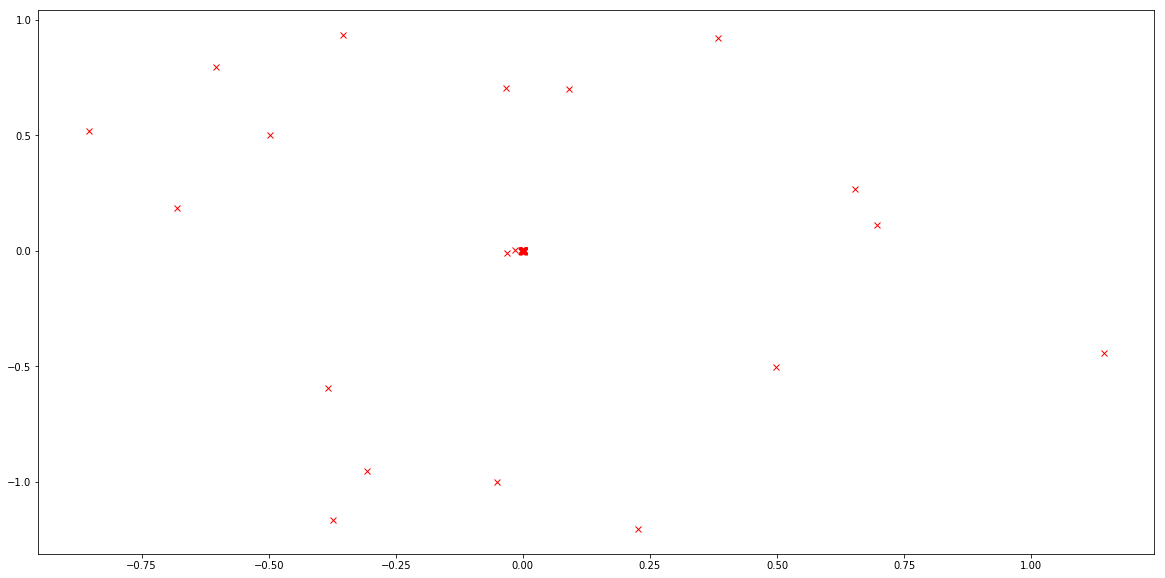

In [30]:
   
%matplotlib inline
import pylab as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(U.iloc[:,0], U.iloc[:,1], 'rx')


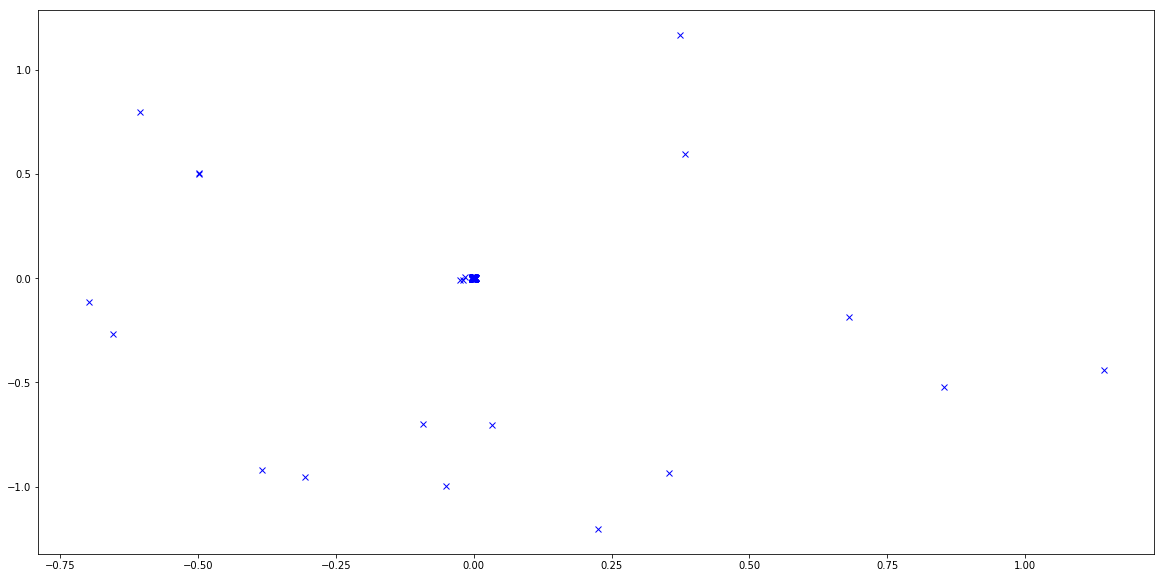

In [31]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(V.iloc[:,0], V.iloc[:,1], 'bx')

# Answer 7 

The observations are:
    1. In movie map, the dense area represents the movies that are rated by same type of the users.
    2. The points which are away from the dense area in movie map represents that these are the movies that are not rated by same type of users.
    3. In user map, the dense area represents that, the user have same movie intrest. Whereas the scattered point at corner shows that the user have different movie intrest.
    

## Is Our Map Enough? Are Our Data Enough?

Is two dimensions really enough to capture the complexity of humans and their artforms? Perhaps we need even more dimensions to capture that complexity. Extending our books analogy further, consider how we should place books that have a historical timeframe as well as some geographical location. Do we really want books from the 2nd World War to sit alongside books from the Roman Empire? Books on the American invasion of Sicily in 1943 are perhaps less related to books about Carthage than those that study the Jewish Revolt from 66-70 (in the Roman Province of Judaea). So books that relate to subjects which are closer in time should be stored together. However, a student of rebellion against empire may also be interested in the relationship between the Jewish Revolt of 66-70 and the Indian Rebellion of 1857, nearly 1800 years later. Whilst the technologies are different, the psychology of the people is shared: a rebellious nation angainst their imperial masters, triggered by misrule with a religious and cultural background. To capture such complexities we would need further dimensions in our latent representation. But are further dimensions justified by the amount of data we have? Can we really understand the facets of a film that only has at most three or four ratings?

## Going Further

If you want to take this model further then you'll need more data. You can use again the MovieLens 100k data but increasing the number of users (for example, for the Steepest Descent Algorithm you can do this by modifying the variable `nUsersInExample` that was set as 10 before).

### Assignment Question 8

Use stochastic gradient descent to make a movie map for the MovieLens 100k data. Plot the map of the movies when you are finished.

*15 marks*

In [18]:
# to find the Y matrix for all the users.

YourStudentID = 356  # Include here the last three digits of your UCard number

ratings = pd.read_csv("./ml-latest-small/ratings.csv") 
"""
ratings is a DataFrame with four columns: userId, movieId, rating and tags. We
first want to identify how many unique users there are. We can use the unique 
method in pandas
"""
indexes_unique_users = ratings['userId'].unique()
n_users = indexes_unique_users.shape[0]   #shape is used to get the current shape of the array
nUsersInExample = n_users
""" 
We randomly select 'nUsers' users with their ratings. We first fix the seed
of the random generator to make sure that we always get the same 'nUsers'
"""
np.random.seed(YourStudentID)
indexes_users = np.random.permutation(n_users)  #Randomly permute a sequence, or return a permuted range.
my_batch_users = indexes_users[0:nUsersInExample]
#print(my_batch_users)
"""
We will use now the list of 'my_batch_users' to create a matrix Y. 
"""
# We need to make a list of the movies that these users have watched
list_movies_each_user = [[] for _ in range(nUsersInExample)]
list_ratings_each_user = [[] for _ in range(nUsersInExample)]
# Movies
list_movies = ratings['movieId'][ratings['userId'] == my_batch_users[0]].values
list_movies_each_user[0] = list_movies 
#print(list_movies)
# Ratings                      
list_ratings = ratings['rating'][ratings['userId'] == my_batch_users[0]].values
list_ratings_each_user[0] = list_ratings
#print(list_ratings)
# Users
n_each_user = list_movies.shape[0]
#print(n_each_user)
list_users = my_batch_users[0]*np.ones((1, n_each_user)) #np.ones > Return a new array of given shape and type, filled with ones


for i in range(1, nUsersInExample):
    # Movies
    local_list_per_user_movies = ratings['movieId'][ratings['userId'] == my_batch_users[i]].values
    list_movies_each_user[i] = local_list_per_user_movies
    list_movies = np.append(list_movies,local_list_per_user_movies)
    # Ratings                                 
    local_list_per_user_ratings = ratings['rating'][ratings['userId'] == my_batch_users[i]].values
    list_ratings_each_user[i] = local_list_per_user_ratings
    list_ratings = np.append(list_ratings, local_list_per_user_ratings)  
    # Users                                   
    n_each_user = local_list_per_user_movies.shape[0]                                                                               
    local_rep_user =  my_batch_users[i]*np.ones((1, n_each_user))    
    list_users = np.append(list_users, local_rep_user)

# Let us first see how many unique movies have been rated
indexes_unique_movies = np.unique(list_movies)
n_movies = indexes_unique_movies.shape[0]
#print(n_movies)
# As it is expected no all users have rated all movies. We will build a matrix Y 
# with NaN inputs and fill according to the data for each user 
temp = np.empty((n_movies,nUsersInExample,))
temp[:] = np.nan
Y_with_NaNs = pd.DataFrame(temp)
for i in range(nUsersInExample):
 local_movies = list_movies_each_user[i]
 ixs = np.in1d(indexes_unique_movies, local_movies)
 Y_with_NaNs.loc[ixs, i] = list_ratings_each_user[i]
print(Y_with_NaNs)
Y_with_NaNs.index = indexes_unique_movies.tolist()
Y_with_NaNs.columns = my_batch_users.tolist()

      0    1    2    3    4    5    6    7    8    9   ...   600  601  602  \
0     NaN  NaN  NaN  NaN  5.0  4.5  4.0  5.0  2.0  4.0 ...   4.0  5.0  5.0   
1     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  3.5 ...   2.0  NaN  NaN   
2     NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN ...   1.0  3.0  NaN   
3     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
4     NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN ...   NaN  3.0  NaN   
5     4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   2.0  NaN  3.0   
6     NaN  NaN  NaN  NaN  4.0  NaN  3.0  NaN  NaN  NaN ...   NaN  NaN  NaN   
7     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
8     NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN ...   3.0  4.0  NaN   
9     NaN  NaN  NaN  NaN  4.0  NaN  NaN  3.0  NaN  3.5 ...   4.0  NaN  3.0   
10    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  3.5 ...   NaN  NaN  3.0   
11    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   3.0

In [19]:
# remove NaN values from the above Y matrix and extract only the required information

p_list_ratings = np.concatenate(list_ratings_each_user).ravel()  # np.ravel > A 1-D array, containing the elements of the input, is returned
p_list_ratings_original = p_list_ratings.tolist()
mean_ratings_train = np.mean(p_list_ratings)  # returns average of array elements
p_list_ratings =  p_list_ratings - mean_ratings_train # remove the mean
p_list_movies = np.concatenate(list_movies_each_user).ravel().tolist()
p_list_users = list_users.tolist()
Y = pd.DataFrame({'users': p_list_users, 'movies': p_list_movies, 'ratingsorig': p_list_ratings_original,'ratings':p_list_ratings.tolist()})
print(Y)

       movies   ratings  ratingsorig  users
0           6  0.500889          4.0   23.0
1          29  0.500889          4.0   23.0
2          32  0.000889          3.5   23.0
3          50  0.500889          4.0   23.0
4          58 -0.499111          3.0   23.0
5         175 -0.499111          3.0   23.0
6         272  0.500889          4.0   23.0
7         293  0.500889          4.0   23.0
8         296  0.000889          3.5   23.0
9         300 -0.499111          3.0   23.0
10        334  0.500889          4.0   23.0
11        431 -0.499111          3.0   23.0
12        454 -0.999111          2.5   23.0
13        541  1.500889          5.0   23.0
14        608  0.000889          3.5   23.0
15        741  0.500889          4.0   23.0
16        750 -0.499111          3.0   23.0
17        778  0.500889          4.0   23.0
18        858  0.000889          3.5   23.0
19        866 -0.499111          3.0   23.0
20        904  0.000889          3.5   23.0
21        912  0.000889         

In [22]:
# Code for question 8 here.

# To find stochastic gradient

iteration = 20
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.02

Y = Y.sample(frac=1).reset_index(drop=True)  # shuffle the dataset
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)
nrows = Y.shape[0]

for i in range(iteration):  
    for j in range (nrows):
        obj = 0.
        gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
        #print(gU)
        gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
        #print(gV)
        
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
        U -= learn_rate*gU
        V -= learn_rate*gV 
    print("After iteration", i, "Objective function: ", obj)
            
print(U)  # final value of U after completing over 20 iterations
print(V)  # final value of V after completing over 20 iterations
        



After iteration 0 Objective function:  3.5622000251386314e-30
After iteration 1 Objective function:  2.4158865222393487e-30
After iteration 2 Objective function:  1.7749370367472766e-30
After iteration 3 Objective function:  4.2185569501858014e-30
After iteration 4 Objective function:  2.4158865222393487e-30
After iteration 5 Objective function:  1.7749370367472766e-30
After iteration 6 Objective function:  1.7749370367472766e-30
After iteration 7 Objective function:  1.9368933308571666e-07
After iteration 8 Objective function:  2.246404687133272e-30
After iteration 9 Objective function:  1.7749370367472766e-30
After iteration 10 Objective function:  3.1554436208840472e-30
After iteration 11 Objective function:  3.35574033510032e-30
After iteration 12 Objective function:  1.7972012451236907e-11
After iteration 13 Objective function:  4.053893910086351e-07
After iteration 14 Objective function:  1.7749370367472766e-30
After iteration 15 Objective function:  1.7749370367472766e-30
After 

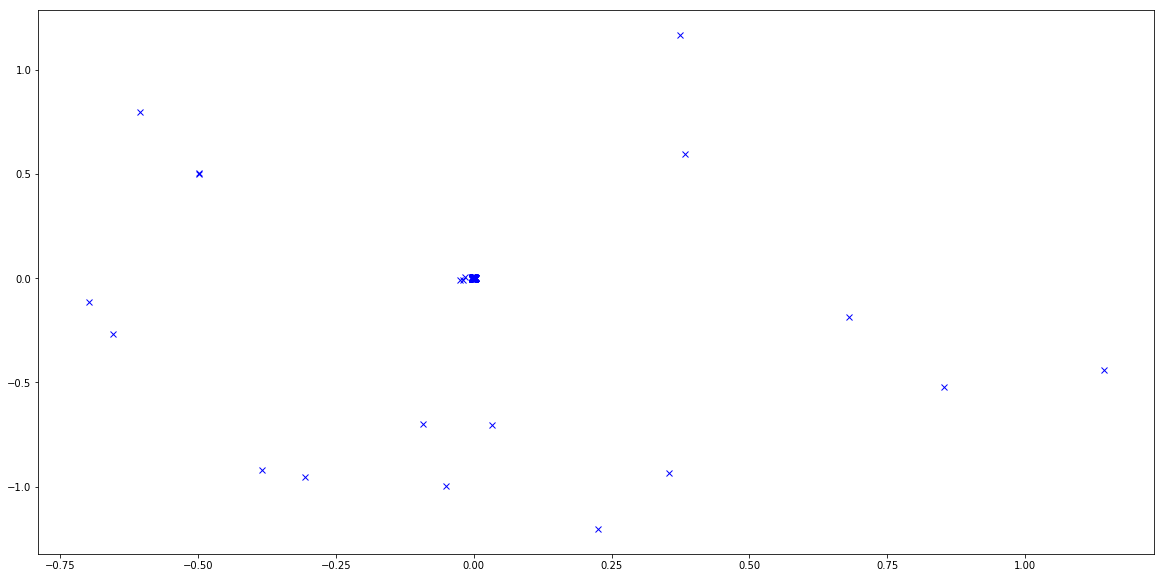

In [28]:
# to plot the movie map

%matplotlib inline
import pylab as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(V.iloc[:,0], V.iloc[:,1], 'bx')


([array([0.000e+00, 0.000e+00, 5.000e+00, 2.000e+00, 4.000e+00, 9.544e+03,
         4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
  array([2.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 9.545e+03,
         0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00])],
 array([-1.20402783, -0.96702519, -0.73002254, -0.4930199 , -0.25601725,
        -0.01901461,  0.21798804,  0.45499068,  0.69199333,  0.92899597,
         1.16599862]),
 <a list of 2 Lists of Patches objects>)

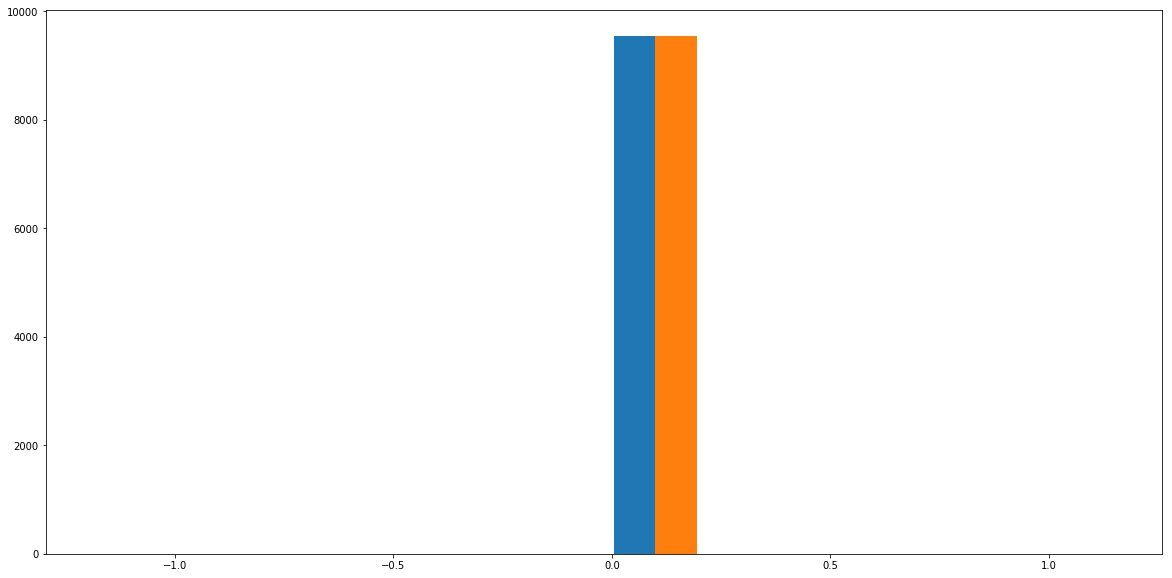

In [29]:
# to get the better insight of data, histogram is plotted. 

plt.rcParams['figure.figsize'] = [20, 10]
plt.hist([V.iloc[:,0], V.iloc[:,1]])


We have repeated stochastic gradient algorithm for 20 iterations so that we can reach till convergence. So from the above histogram plot, we can observe that maximum data lies around 0 and has almost reached till convergence.